# 06_SIMBA-Spatial-GeneExpr-Corr

In [1]:
%load_ext autoreload
%autoreload 2

In [67]:
import scanpy as sc
import seaborn as sns
import matplotlib.pyplot as plt
from src.plot import plot_spatial, palette_celltype, plot_obs_spatial
import pandas as pd
import numpy as np
palette_entity_anno = palette_celltype.copy()
palette_entity_anno['gene'] = "lightgray"

In [4]:
import os
import simba as si
si.__version__

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_csv from `anndata` is deprecated. Import anndata.io.read_csv instead.
  warnings.warn(msg, FutureWarning)
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_excel from `anndata` is deprecated. Import anndata.io.read_excel instead.
  warnings.warn(msg, FutureWarning)
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/anndata/utils.py:429: FutureWarning: Importing read_hdf from `anndata` is deprecated. Import anndata.io.read_hdf instead.
  warnings.warn(msg, FutureWarning)
/Users/cchu/opt/anaconda3/envs/env_si

'1.2'

In [5]:
workdir = 'data/06'
si.settings.set_workdir(workdir)

Saving results in: data/06


In [6]:
si.settings.set_figure_params(
    dpi=80,
    style='white',
    fig_size=[5,5],
    rc={'image.cmap': 'viridis'}
)

from matplotlib_inline.backend_inline import set_matplotlib_formats
set_matplotlib_formats('retina')

# Data

In [7]:
h5_fn = "./result_simba_rnaseq_spatialLIBD/data/151673.h5ad"
adata_CG = sc.read_h5ad(h5_fn)
adata_CG

AnnData object with n_obs × n_vars = 3611 × 16578
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'spatialLIBD', 'leiden'
    var: 'gene_ids', 'feature_types', 'genome', 'n_cells', 'mito', 'n_cells_by_counts', 'mean_counts', 'log1p_mean_counts', 'pct_dropout_by_counts', 'total_counts', 'log1p_total_counts'
    uns: 'leiden', 'log1p', 'neighbors', 'pca', 'spatial', 'umap'
    obsm: 'X_pca', 'X_umap', 'spatial'
    varm: 'PCs'
    layers: 'counts'
    obsp: 'connectivities', 'distances'

# Spatial embedding

Like in notebook 02, but also use gene correlation

## Adjacency

In [144]:
tmp_obs = adata_CG.obs.copy()
tmp_obs.index.name = 'barcode'
tmp_obs = tmp_obs.reset_index().set_index(['array_row', 'array_col']).sort_index()
spatial_adj_df = pd.DataFrame(index=adata_CG.obs.index, columns = adata_CG.obs.index, dtype=np.float32).fillna(0.0)

In [145]:
radius = 5
for barcode, r in adata_CG.obs.iterrows():
    row, col = r['array_row'], r['array_col']

    # neighbors = adata_CG.obs[
    #     adata_CG.obs['array_row'].between(row - radius, row + radius) & 
    #     adata_CG.obs['array_col'].between(col - radius, col + radius)
    # ].index

    neighbors = adata_CG.obs[
        np.sqrt(np.power(adata_CG.obs['array_row'] - row, 2) + np.power(adata_CG.obs['array_col'] - col, 2)) < radius
    ].index
    spatial_adj_df.loc[barcode, neighbors] = 1.0


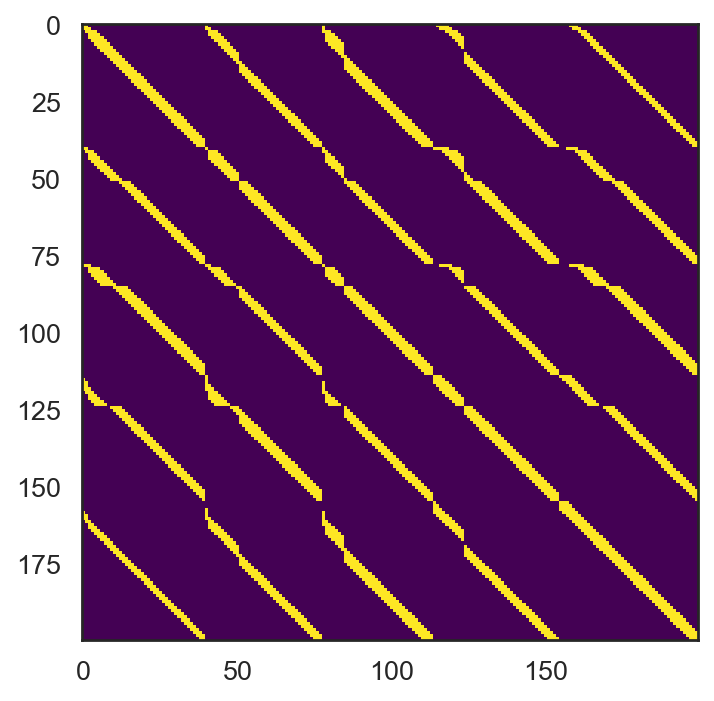

In [146]:
sorted_barcodes = adata_CG.obs.sort_values(by=['array_row', 'array_col']).index
plt.imshow(spatial_adj_df.loc[sorted_barcodes, sorted_barcodes].iloc[:200, :200])

## Gene correlation

Todo: use spatially variable genes or highly variable genes only for correlation

Covariance of $X_{ii}$ is the variance of $X_i$

In [125]:
expr_cov = np.cov(adata_CG.X.toarray())

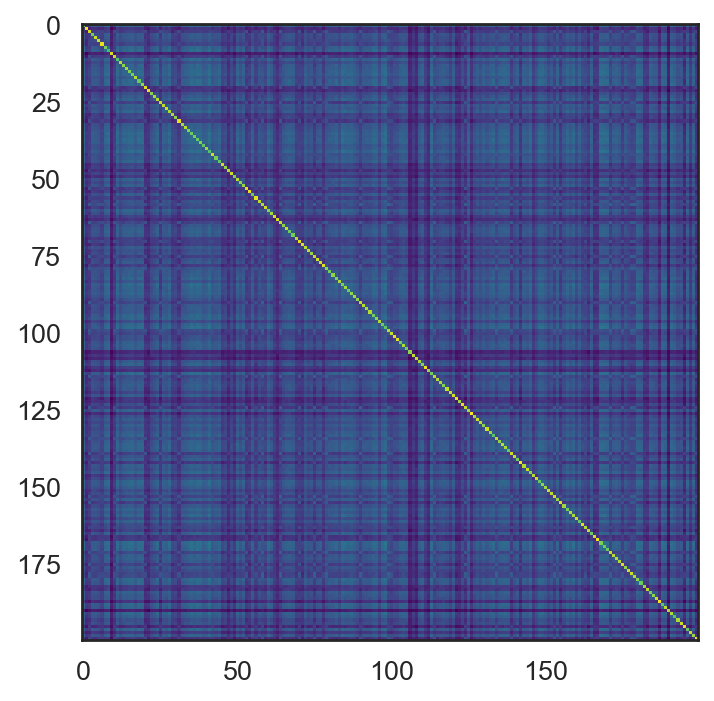

In [126]:
plt.imshow(expr_cov[:200, :200])

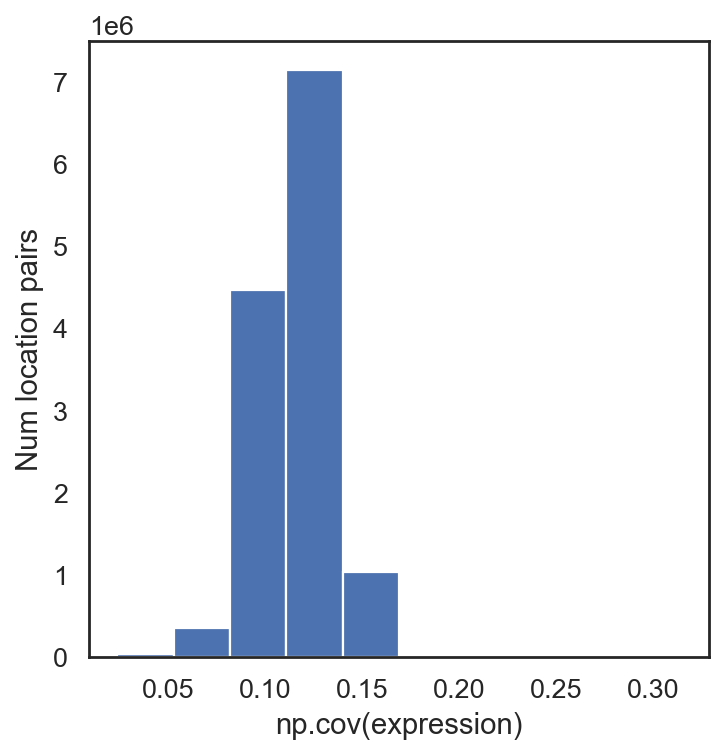

In [65]:
plt.hist(expr_cov.flatten())
plt.xlabel('np.cov(expression)')
plt.ylabel('Num location pairs')
plt.show()

In [147]:
cov_df = pd.DataFrame(index=spatial_adj_df.index, columns=spatial_adj_df.columns, data=expr_cov)

In [148]:
weighted_spatial_adj_df = spatial_adj_df * expr_cov

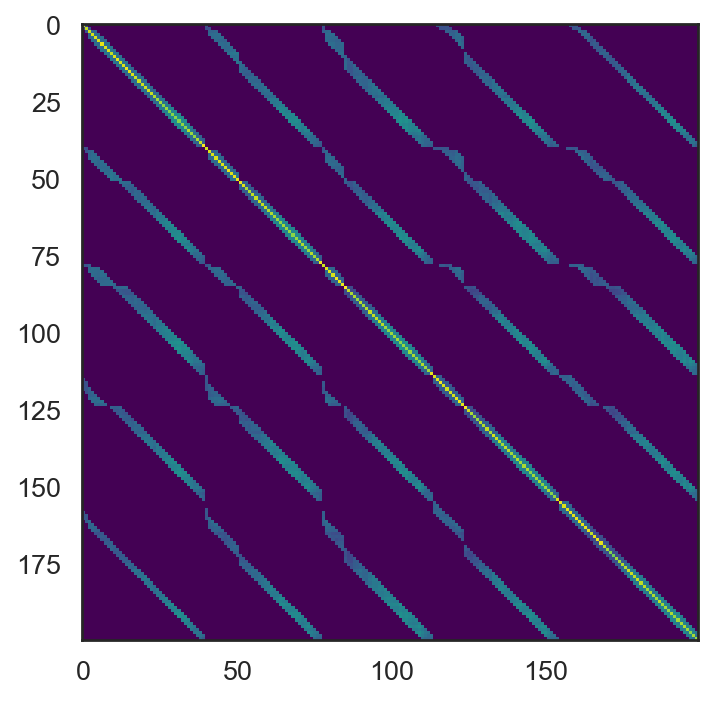

In [149]:
plt.imshow(weighted_spatial_adj_df.loc[sorted_barcodes, sorted_barcodes].iloc[:200, :200])

In [150]:
import anndata as ad
from scipy.sparse import csr_matrix

In [151]:
weighted_spatial_adj_matrix = csr_matrix(weighted_spatial_adj_df, dtype=np.float32)
adata_N = ad.AnnData(weighted_spatial_adj_matrix)
adata_N

AnnData object with n_obs × n_vars = 3611 × 3611

In [152]:
adata_N.layers['simba'] = adata_N.X

adata_N.obs.index = weighted_spatial_adj_df.index
adata_N.var.index = weighted_spatial_adj_df.index

adata_N.obs = adata_CG.obs.copy()
adata_N.var.index = adata_CG.obs.index

In [153]:
adata_N

AnnData object with n_obs × n_vars = 3611 × 3611
    obs: 'in_tissue', 'array_row', 'array_col', 'n_genes_by_counts', 'log1p_n_genes_by_counts', 'total_counts', 'log1p_total_counts', 'pct_counts_in_top_50_genes', 'pct_counts_in_top_100_genes', 'pct_counts_in_top_200_genes', 'pct_counts_in_top_500_genes', 'spatialLIBD', 'leiden', 'pbg_id'
    layers: 'simba'

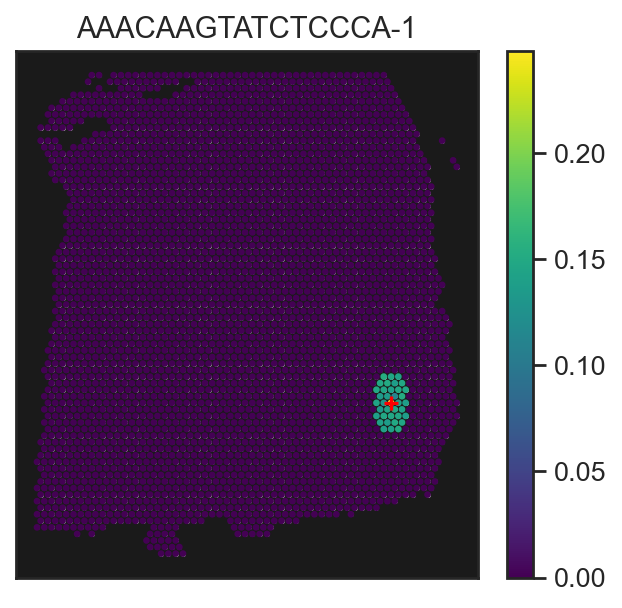

In [154]:
barcode = 'AAACAAGTATCTCCCA-1'
fig, axes = plot_spatial(adata_N, color=[barcode], s=4)
axes[0][0].scatter(x=adata_N.obs.loc[barcode]['array_col'], y=adata_N.obs.loc[barcode]['array_row'], color='red', marker='+')
plt.show()

### Plot full covariance

In [155]:
cov_matrix = csr_matrix(cov_df, dtype=np.float32)
adata_COV = ad.AnnData(cov_matrix)
adata_COV.obs.index = cov_df.index
adata_COV.var.index = cov_df.index
adata_COV.obs = adata_CG.obs.copy()
adata_COV.var.index = adata_CG.obs.index

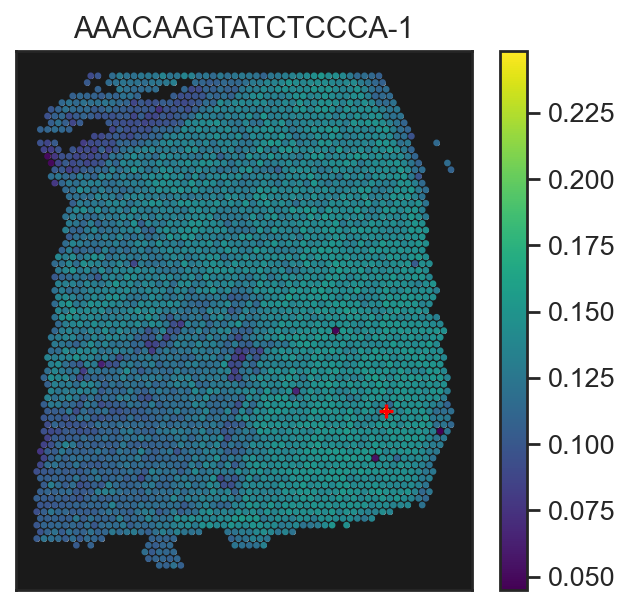

In [156]:
barcode = 'AAACAAGTATCTCCCA-1'
fig, axes = plot_spatial(adata_COV, color=[barcode], s=4)
axes[0][0].scatter(x=adata_COV.obs.loc[barcode]['array_col'], y=adata_COV.obs.loc[barcode]['array_row'], color='red', marker='+')
plt.show()

In [159]:
adata_CG.obs.query('array_col < 100 and array_row < 100').head(3)

in_tissue  array_row  array_col  n_genes_by_counts  \
AAACAATCTACTAGCA-1          1          3         43               1149   
AAACACCAATAACTGC-1          1         59         19               1956   
AAACAGAGCGACTCCT-1          1         14         94               2413   

                    log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
AAACAATCTACTAGCA-1                 7.047517        1666.0            7.418781   
AAACACCAATAACTGC-1                 7.579168        3765.0            8.233768   
AAACAGAGCGACTCCT-1                 7.789040        5422.0            8.598405   

                    pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
AAACAATCTACTAGCA-1                   22.989196                    30.192077   
AAACACCAATAACTGC-1                   26.002656                    33.173971   
AAACAGAGCGACTCCT-1                   32.700111                    38.472888   

                    pct_counts_in_top_200_genes  pct_counts_in_top_500_genes  \
AAACAATCTACTAGCA-1                    42.196879                    61.044418   
AAACACCAATAACTGC-1                    42.576361                    59.760956   
AAACAGAGCGACTCCT-1                    46.532645                    60.051641   

                   spatialLIBD leiden pbg_id  
AAACAATCTACTAGCA-1          L1      1    C.1  
AAACACCAATAACTGC-1          WM      0    C.2  
AAACAGAGCGACTCCT-1          L3      2    C.3

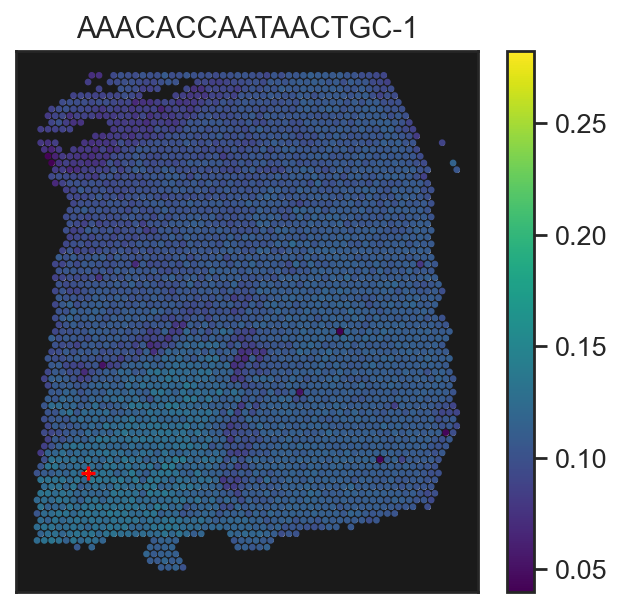

In [158]:
barcode = 'AAACACCAATAACTGC-1'
fig, axes = plot_spatial(adata_COV, color=[barcode], s=4)
axes[0][0].scatter(x=adata_COV.obs.loc[barcode]['array_col'], y=adata_COV.obs.loc[barcode]['array_row'], color='red', marker='+')
plt.show()

## Pearson correlation

In [110]:
corrcoef_cov = np.corrcoef(adata_CG.X.toarray())

In [113]:
corrcoef_cov.shape

(3611, 3611)

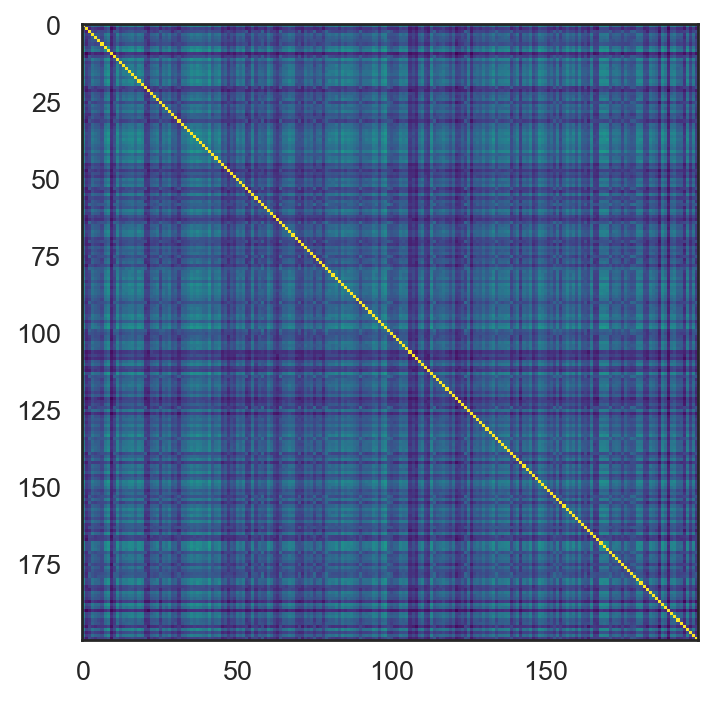

In [111]:
plt.imshow(corrcoef_cov[:200, :200])

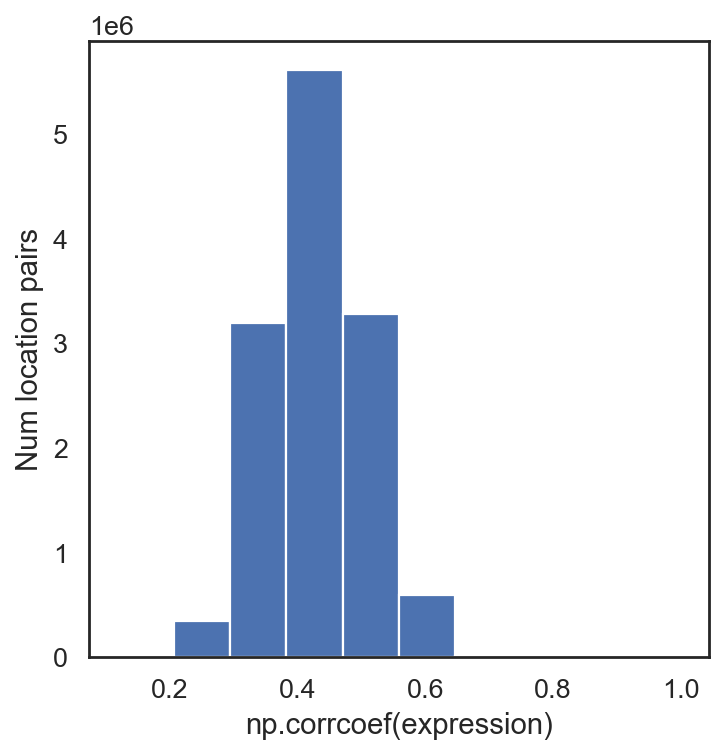

In [112]:
plt.hist(corrcoef_cov.flatten())
plt.xlabel('np.corrcoef(expression)')
plt.ylabel('Num location pairs')
plt.show()

In [114]:
corrcoef_df = pd.DataFrame(index=spatial_adj_df.index, columns=spatial_adj_df.columns, data=corrcoef_cov)

In [115]:
corrcoef_matrix = csr_matrix(corrcoef_df, dtype=np.float32)
adata_CORR = ad.AnnData(corrcoef_matrix)
adata_CORR.obs.index = corrcoef_df.index
adata_CORR.var.index = corrcoef_df.index
adata_CORR.obs = adata_CG.obs.copy()
adata_CORR.var.index = adata_CG.obs.index

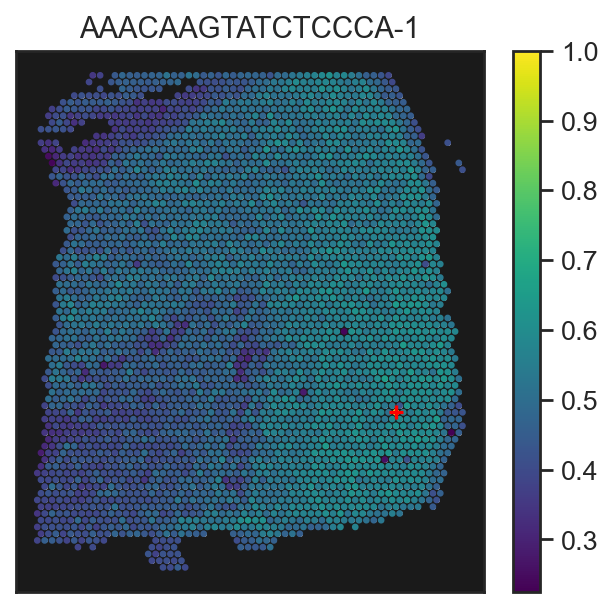

In [116]:
barcode = 'AAACAAGTATCTCCCA-1'
fig, axes = plot_spatial(adata_CORR, color=[barcode], s=4)
axes[0][0].scatter(x=adata_CORR.obs.loc[barcode]['array_col'], y=adata_CORR.obs.loc[barcode]['array_row'], color='red', marker='+')
plt.show()

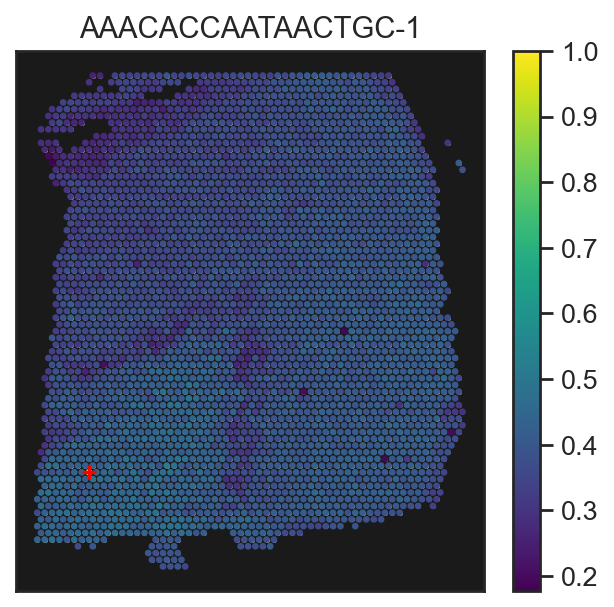

In [117]:
barcode = 'AAACACCAATAACTGC-1'
fig, axes = plot_spatial(adata_CORR, color=[barcode], s=4)
axes[0][0].scatter(x=adata_CORR.obs.loc[barcode]['array_col'], y=adata_CORR.obs.loc[barcode]['array_row'], color='red', marker='+')
plt.show()

In [160]:
corr_weighted_spatial_adj_df = spatial_adj_df * corrcoef_cov

In [209]:
corr_weighted_spatial_adj_matrix = csr_matrix(corr_weighted_spatial_adj_df, dtype=np.float32)
adata_N_corr = ad.AnnData(corr_weighted_spatial_adj_matrix)
adata_N_corr

AnnData object with n_obs × n_vars = 3611 × 3611

In [210]:
adata_N_corr.layers['simba'] = adata_N.X

adata_N_corr.obs.index = corr_weighted_spatial_adj_df.index
adata_N_corr.var.index = corr_weighted_spatial_adj_df.index

adata_N_corr.obs = adata_CG.obs.copy()
adata_N_corr.var.index = adata_CG.obs.index

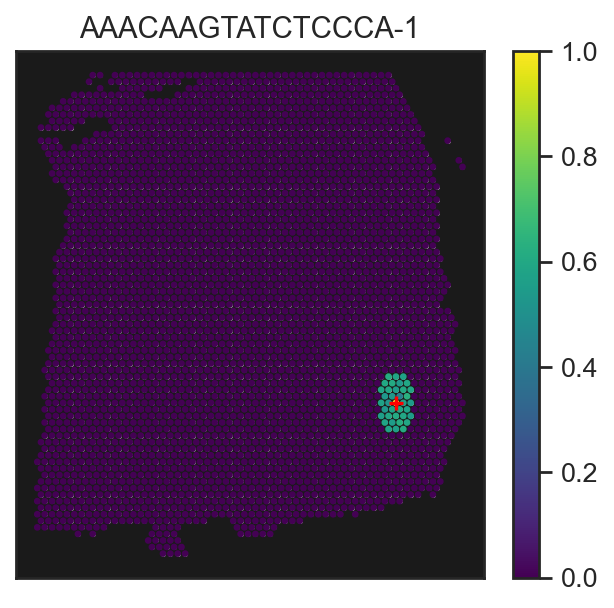

In [211]:
barcode = 'AAACAAGTATCTCCCA-1'
fig, axes = plot_spatial(adata_N_corr, color=[barcode], s=4)
axes[0][0].scatter(x=adata_N_corr.obs.loc[barcode]['array_col'], y=adata_N_corr.obs.loc[barcode]['array_row'], color='red', marker='+')
plt.show()

# Generate Graph

In [212]:
si.tl.gen_graph(
    list_CC=[adata_N_corr],
    # prefix='N',
    # layer='simba',
    use_highly_variable=False, 
    dirname='graph0'
)

UnboundLocalError: cannot access local variable 'df_cells_obs' where it is not associated with a value

In [208]:
adata_N_corr.obs

in_tissue  array_row  array_col  n_genes_by_counts  \
AAACAAGTATCTCCCA-1          1         50        102               3575   
AAACAATCTACTAGCA-1          1          3         43               1149   
AAACACCAATAACTGC-1          1         59         19               1956   
AAACAGAGCGACTCCT-1          1         14         94               2413   
AAACAGCTTTCAGAAG-1          1         43          9               2255   
...                       ...        ...        ...                ...   
TTGTTTCACATCCAGG-1          1         58         42               2166   
TTGTTTCATTAGTCTA-1          1         60         30               1558   
TTGTTTCCATACAACT-1          1         45         27               1341   
TTGTTTGTATTACACG-1          1         73         41               1416   
TTGTTTGTGTAAATTC-1          1          7         51               2921   

                    log1p_n_genes_by_counts  total_counts  log1p_total_counts  \
AAACAAGTATCTCCCA-1                 8.182000        8447.0            9.041685   
AAACAATCTACTAGCA-1                 7.047517        1666.0            7.418781   
AAACACCAATAACTGC-1                 7.579168        3765.0            8.233768   
AAACAGAGCGACTCCT-1                 7.789040        5422.0            8.598405   
AAACAGCTTTCAGAAG-1                 7.721349        4269.0            8.359369   
...                                     ...           ...                 ...   
TTGTTTCACATCCAGG-1                 7.681099        4320.0            8.371243   
TTGTTTCATTAGTCTA-1                 7.351800        2759.0            7.922986   
TTGTTTCCATACAACT-1                 7.201916        2320.0            7.749753   
TTGTTTGTATTACACG-1                 7.256297        2327.0            7.752765   
TTGTTTGTGTAAATTC-1                 7.980024        6274.0            8.744328   

                    pct_counts_in_top_50_genes  pct_counts_in_top_100_genes  \
AAACAAGTATCTCCCA-1                   24.766189                    30.649935   
AAACAATCTACTAGCA-1                   22.989196                    30.192077   
AAACACCAATAACTGC-1                   26.002656                    33.173971   
AAACAGAGCGACTCCT-1                   32.700111                    38.472888   
AAACAGCTTTCAGAAG-1                   23.846334                    30.264699   
...                                        ...                          ...   
TTGTTTCACATCCAGG-1                   22.962963                    30.416667   
TTGTTTCATTAGTCTA-1                   26.458862                    34.215295   
TTGTTTCCATACAACT-1                   31.120690                    37.974138   
TTGTTTGTATTACACG-1                   25.182639                    33.003868   
TTGTTTGTGTAAATTC-1                   24.258846                    30.188078   

                    pct_counts_in_top_200_genes  pct_counts_in_top_500_genes  \
AAACAAGTATCTCCCA-1                    38.794838                    52.740618   
AAACAATCTACTAGCA-1                    42.196879                    61.044418   
AAACACCAATAACTGC-1                    42.576361                    59.760956   
AAACAGAGCGACTCCT-1                    46.532645                    60.051641   
AAACAGCTTTCAGAAG-1                    38.908409                    54.813774   
...                                         ...                          ...   
TTGTTTCACATCCAGG-1                    40.740741                    57.824074   
TTGTTTCATTAGTCTA-1                    43.856470                    61.652773   
TTGTTTCCATACAACT-1                    47.284483                    63.750000   
TTGTTTGTATTACACG-1                    42.801891                    60.636012   
TTGTTTGTGTAAATTC-1                    38.284986                    53.076187   

                   spatialLIBD leiden  pbg_id  
AAACAAGTATCTCCCA-1          L3      6     C.0  
AAACAATCTACTAGCA-1          L1      1     C.1  
AAACACCAATAACTGC-1          WM      0     C.2  
AAACAGAGCGACTCCT-1          L3      2     C.3  
AAACAGCT

# Train

In [172]:
si.tl.pbg_train(auto_wd=True, save_wd=True, output='model_corr')

Auto-estimating weight decay ...
`.settings.pbg_params['wd']` has been updated to 0.281104
Weight decay being used for training is 0.281104
Converting input data ...
[2025-01-16 17:31:32.104653] Found some files that indicate that the input data has already been preprocessed, not doing it again.
[2025-01-16 17:31:32.105159] These files are in: data/06/pbg/graph0/input/entity, data/06/pbg/graph0/input/edge
Starting training ...


/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: T

Finished


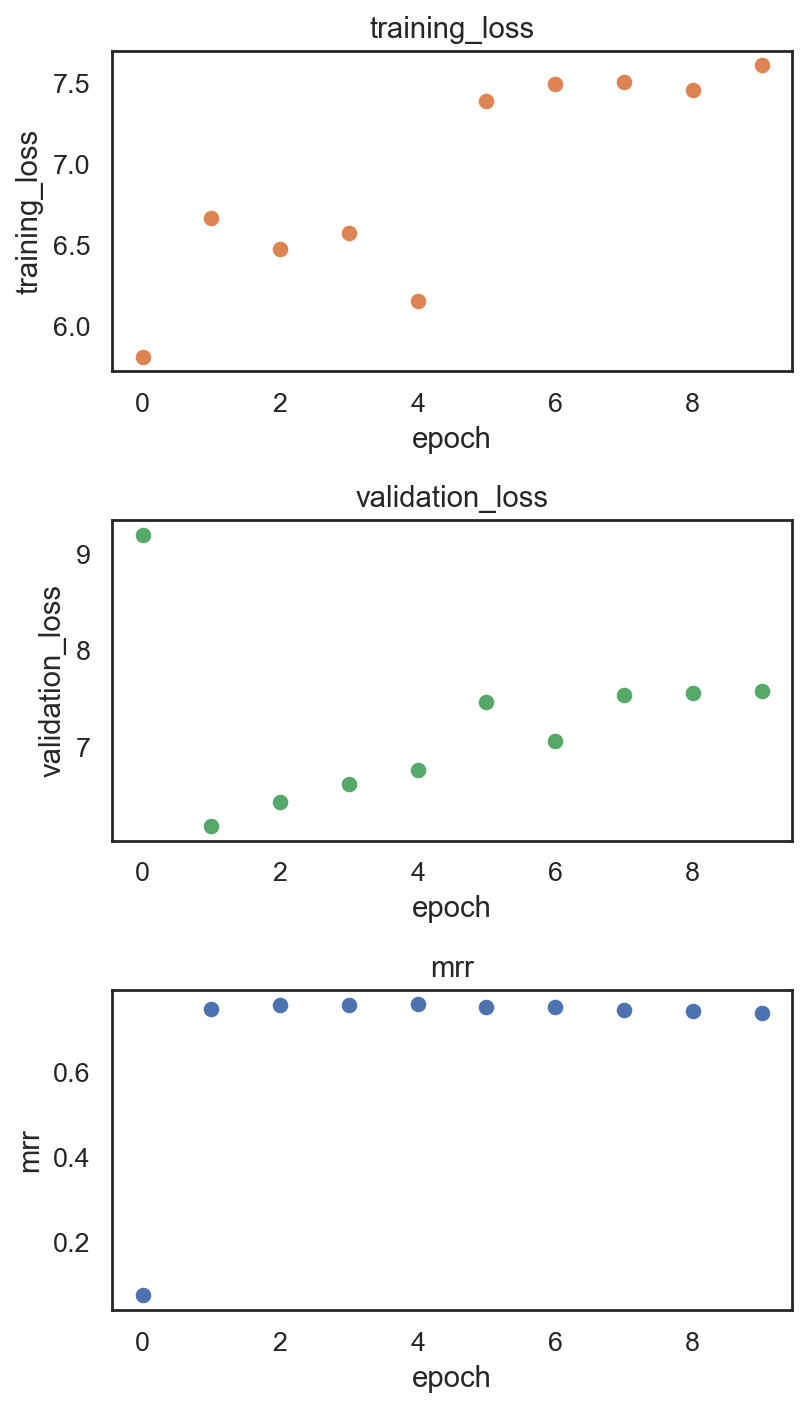

In [173]:
si.pl.pbg_metrics(fig_ncol=1)

# Post embedding

In [174]:
# read in entity embeddings obtained from pbg training.
dict_adata = si.read_embedding()
dict_adata

{'N0': AnnData object with n_obs × n_vars = 3611 × 50}

In [175]:
adata_N0 = dict_adata['N0']  # embeddings of cells

In [176]:
adata_N0.obs['spatialLIBD'] = adata_CG[adata_N0.obs_names,:].obs['spatialLIBD'].copy()
adata_N0

AnnData object with n_obs × n_vars = 3611 × 50
    obs: 'spatialLIBD'

In [177]:
adata_N0.var.index = adata_N0.obs.index

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


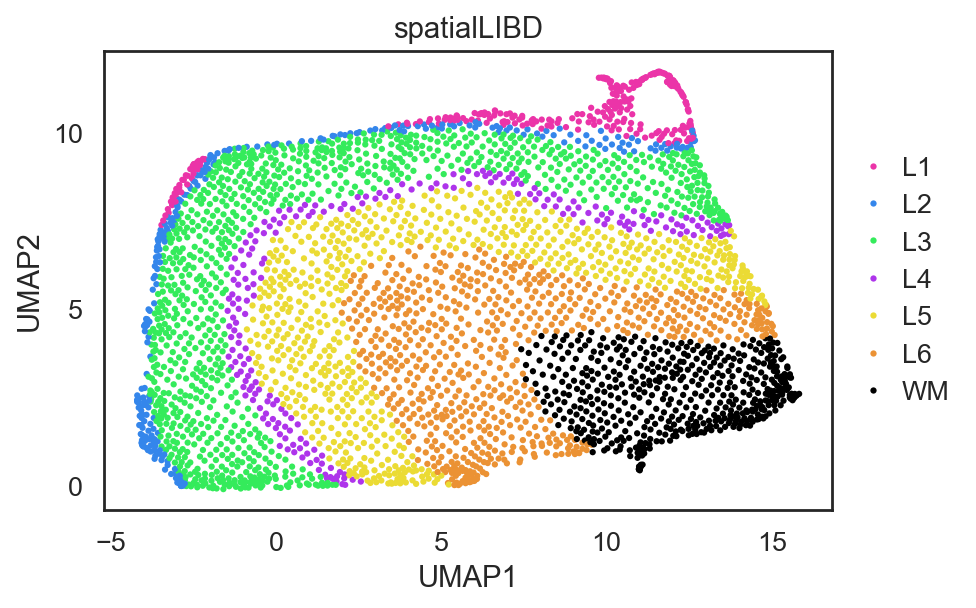

In [178]:
si.tl.umap(adata_N0,n_neighbors=15,n_components=2)
si.pl.umap(
    adata_N0,color=['spatialLIBD'],
    dict_palette={'spatialLIBD': palette_celltype},
    fig_size=(6,4),
    drawing_order='random'
)

In [179]:
si.preprocessing.pca(adata_N0)

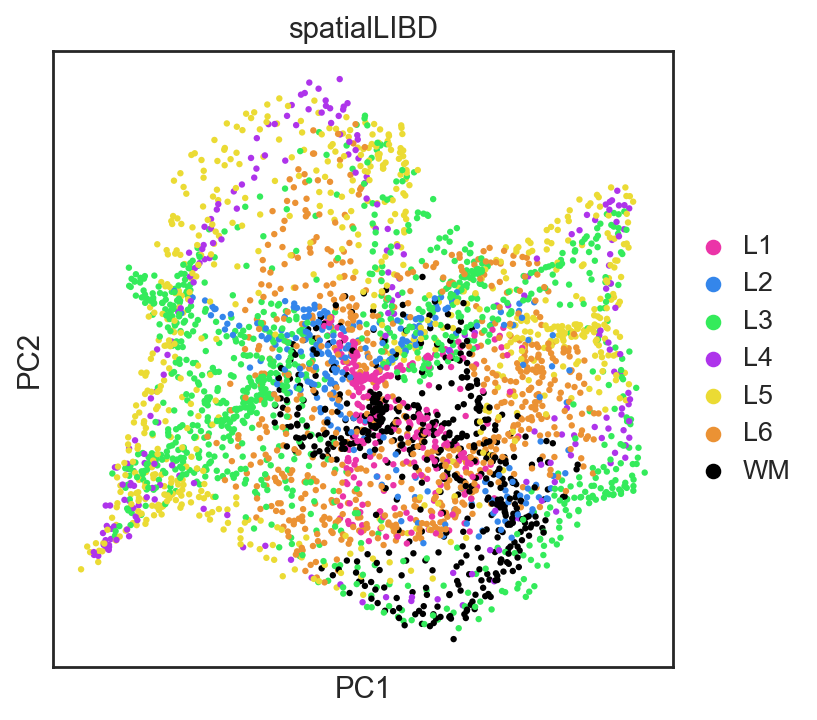

In [180]:
sc.pl.pca(adata_N0, color=['spatialLIBD'], palette=palette_celltype, dimensions=(0, 1))

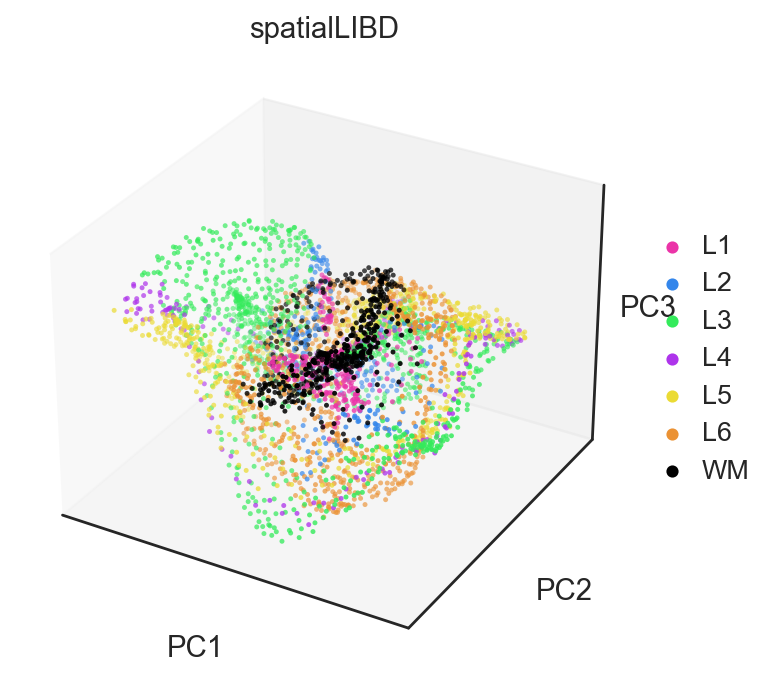

In [181]:
sc.pl.pca(adata_N0, color=['spatialLIBD'], palette=palette_celltype, projection='3d')

# RNAseq

## Discretize

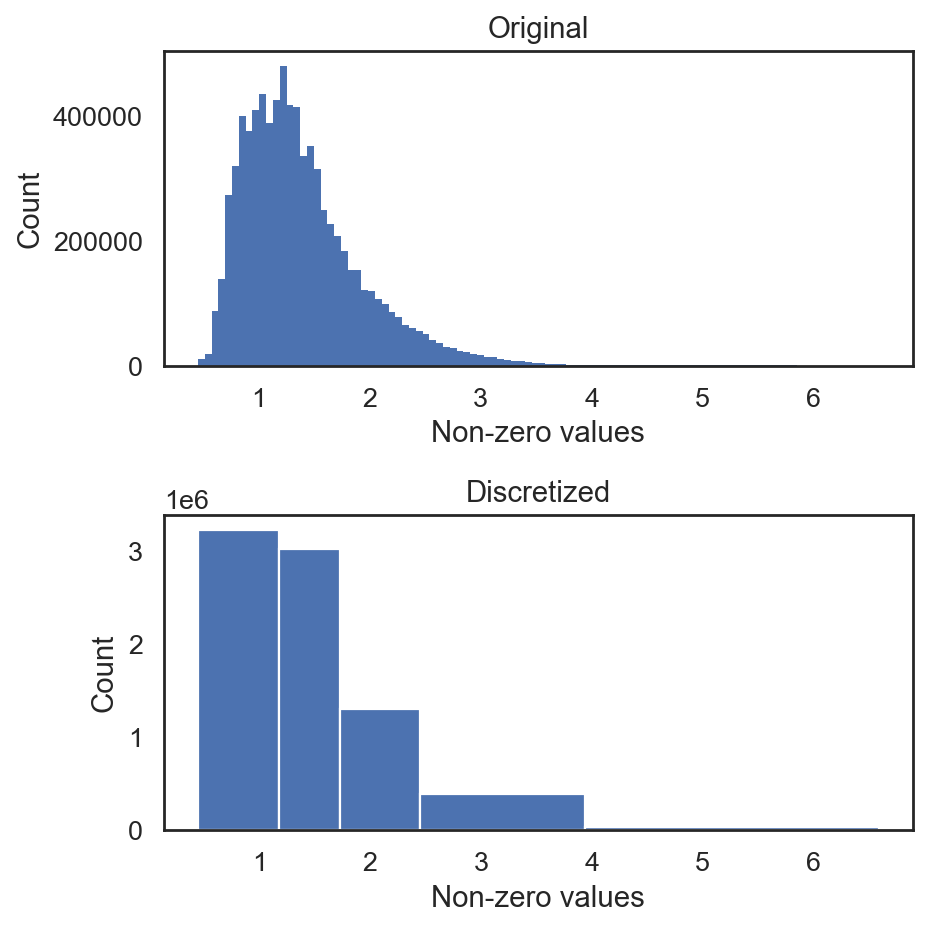

In [43]:
si.tl.discretize(adata_CG,n_bins=5)
si.pl.discretize(adata_CG,kde=False)

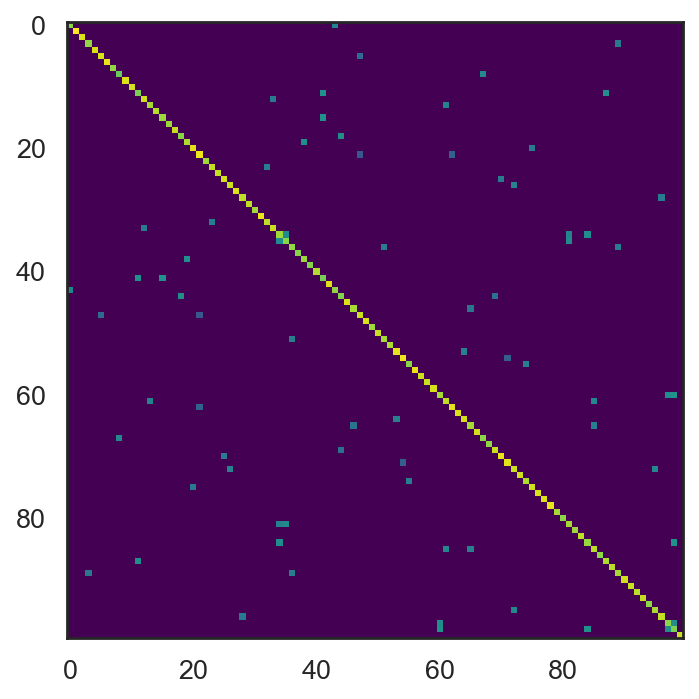

In [206]:
plt.imshow(adata_N_corr.layers['simba'][:100, :100].toarray())

In [213]:
si.tl.gen_graph(
    list_CG=[adata_CG],
    list_CC=[adata_N_corr],
    layer='simba',
    use_highly_variable=False, 
    dirname='graph_SCG_corr'# spatial cell gene, was graph_SCG using adata_N
)

relation0: source: C, destination: G
#edges: 3219964
relation1: source: C, destination: G
#edges: 3011006
relation2: source: C, destination: G
#edges: 1298252
relation3: source: C, destination: G
#edges: 390354
relation4: source: C, destination: G
#edges: 36477
relation5: source: C, destination: C
#edges: 126057
Total number of edges: 8082110
Writing graph file "pbg_graph.txt" to "data/06/pbg/graph_SCG_corr" ...
Finished.


In [214]:
si.settings.pbg_params


{'entity_path': 'data/06/pbg/graph_SCG_corr/input/entity',
 'edge_paths': ['data/06/pbg/graph_SCG_corr/input/edge'],
 'checkpoint_path': 'data/06/pbg/graph_SCG_corr/model_SCG_corr',
 'entities': {'N0': {'num_partitions': 1},
  'C': {'num_partitions': 1},
  'G': {'num_partitions': 1}},
 'relations': [{'name': 'r0',
   'lhs': 'C',
   'rhs': 'G',
   'operator': 'none',
   'weight': 1.0},
  {'name': 'r1', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 2.0},
  {'name': 'r2', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 3.0},
  {'name': 'r3', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 4.0},
  {'name': 'r4', 'lhs': 'C', 'rhs': 'G', 'operator': 'none', 'weight': 5.0},
  {'name': 'r5', 'lhs': 'C', 'rhs': 'C', 'operator': 'none', 'weight': 10.0}],
 'dynamic_relations': False,
 'dimension': 50,
 'global_emb': False,
 'comparator': 'dot',
 'num_epochs': 10,
 'workers': 4,
 'num_batch_negs': 50,
 'num_uniform_negs': 50,
 'loss_fn': 'softmax',
 'lr': 0.1,
 'early_stopping'

In [217]:
reweight_CC_dict_config = si.settings.pbg_params.copy()
reweight_CC_dict_config['relations'][-1]['weight'] = 1.0

`model_SCG_corr`: kept default weight for CC edges at 10.0
`model_SCG_corr_v2`: updated default weight for CC edges to 1.0

In [219]:
si.tl.pbg_train(pbg_params = reweight_CC_dict_config, auto_wd=True, save_wd=True, output='model_SCG_corr_v2')

Auto-estimating weight decay ...
`.settings.pbg_params['wd']` has been updated to 0.004384
Weight decay being used for training is 0.004384
Converting input data ...
[2025-01-22 13:19:03.139588] Found some files that indicate that the input data has already been preprocessed, not doing it again.
[2025-01-22 13:19:03.140333] These files are in: data/06/pbg/graph_SCG_corr/input/entity, data/06/pbg/graph_SCG_corr/input/edge
Starting training ...


/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: TypedStorage is deprecated. It will be removed in the future and UntypedStorage will be the only storage class. This should only matter to you if you are using storages directly.  To access UntypedStorage directly, use tensor.untyped_storage() instead of tensor.storage()
  if data.numel() == 0 and data.storage().size() == 0:
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/torchbiggraph/tensorlist.py:86: UserWarning: T

Finished


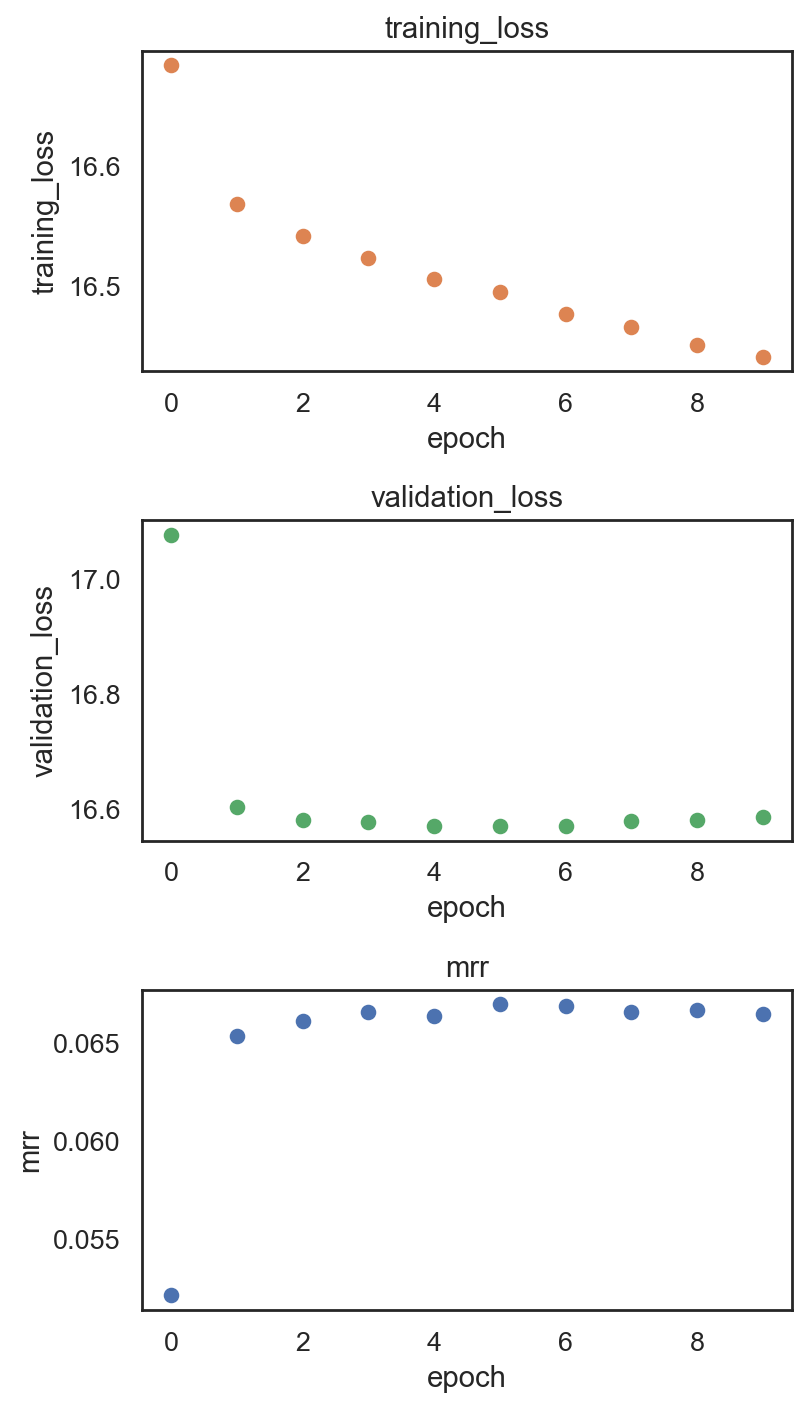

In [220]:
si.pl.pbg_metrics(fig_ncol=1)

## Post training

In [221]:
# read in entity embeddings obtained from pbg training.
dict_adata = si.read_embedding()
dict_adata

{'G': AnnData object with n_obs × n_vars = 16578 × 50,
 'C': AnnData object with n_obs × n_vars = 3611 × 50}

In [222]:
adata_C = dict_adata['C']  # embeddings of cells
adata_G = dict_adata['G']  # embeddings of genes

In [223]:
adata_C.obs['spatialLIBD'] = adata_CG[adata_C.obs_names,:].obs['spatialLIBD'].copy()
adata_C

AnnData object with n_obs × n_vars = 3611 × 50
    obs: 'spatialLIBD'

/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


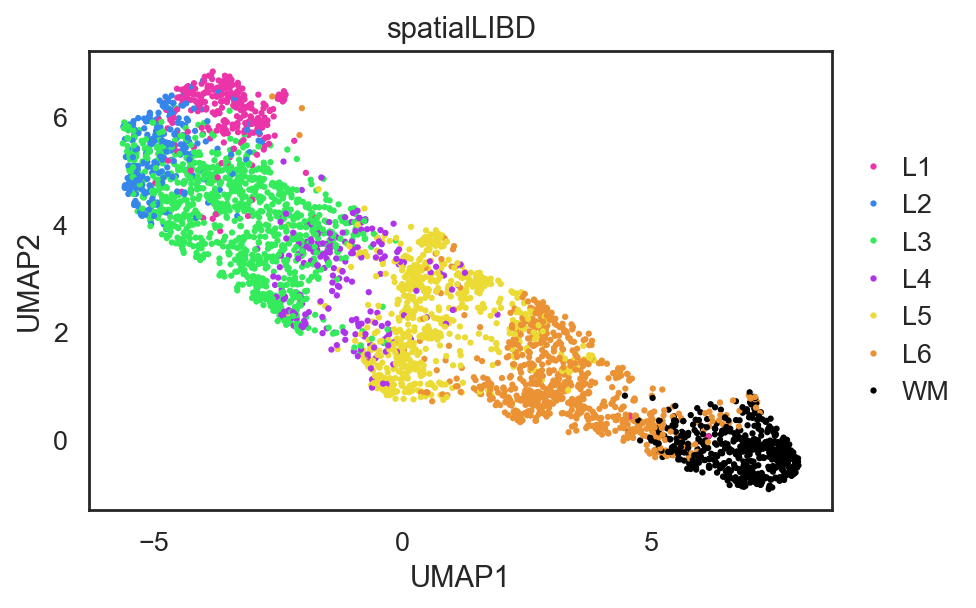

In [224]:
si.tl.umap(adata_C,n_neighbors=15,n_components=2)
si.pl.umap(
    adata_C,color=['spatialLIBD'],
    dict_palette={'spatialLIBD': palette_celltype},
    fig_size=(6,4),
    drawing_order='random'
)

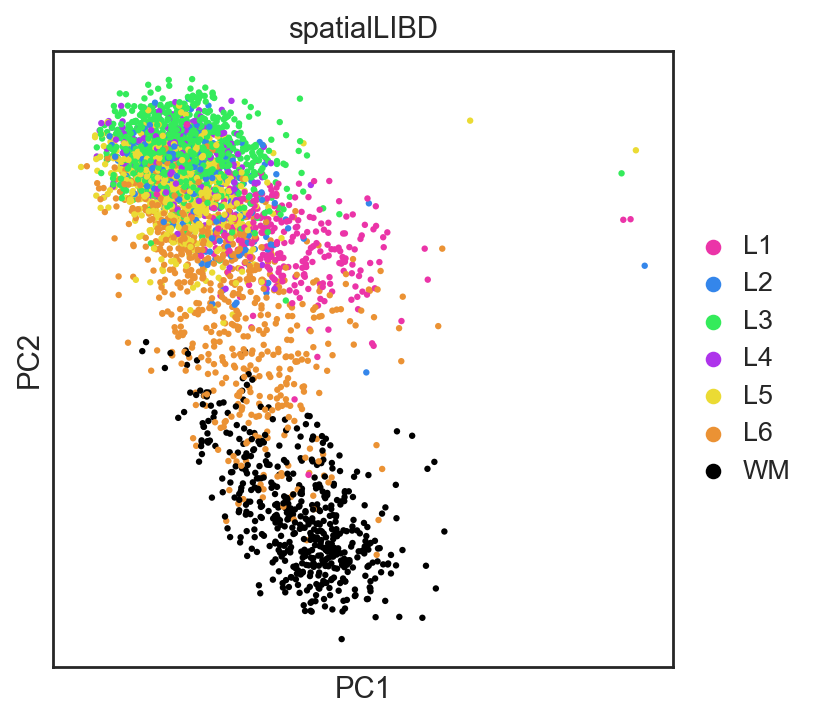

In [225]:
si.preprocessing.pca(adata_C)
sc.pl.pca(adata_C, color=['spatialLIBD'], palette=palette_celltype, dimensions=(0, 1))

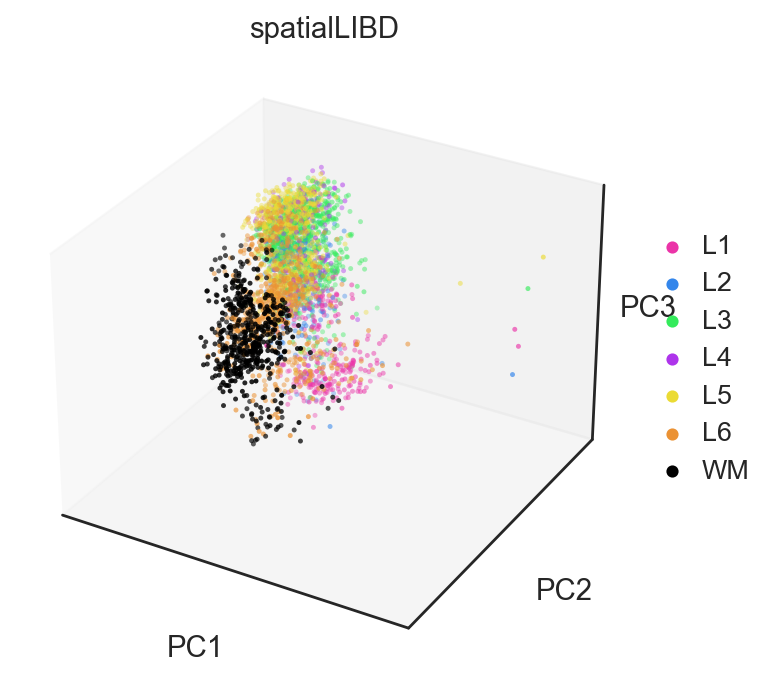

In [226]:
sc.pl.pca(adata_C, color=['spatialLIBD'], palette=palette_celltype, projection='3d')

## Joint embedding

In [230]:
si.pp.select_variable_genes(adata_CG,layer='counts', n_top_genes=3000)
var_genes = adata_CG.var_names[adata_CG.var['highly_variable']].tolist()

3000 variable genes are selected.


In [231]:
# embed cells and genes into the same space
adata_all = si.tl.embed(adata_ref=adata_C,list_adata_query=[adata_G], T=0.5)
## add annotations of cells and genes
adata_all.obs['entity_anno'] = ""
adata_all.obs.loc[adata_C.obs_names, 'entity_anno'] = adata_all.obs.loc[adata_C.obs_names, 'spatialLIBD']
adata_all.obs.loc[adata_G.obs_names, 'entity_anno'] = 'gene'

si.tl.umap(adata_all,n_neighbors=15,n_components=2)

Performing softmax transformation for query data 0;


/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/sklearn/utils/deprecation.py:151: FutureWarning: 'force_all_finite' was renamed to 'ensure_all_finite' in 1.6 and will be removed in 1.8.
  warnings.warn(
/Users/cchu/opt/anaconda3/envs/env_simba/lib/python3.11/site-packages/umap/umap_.py:1952: UserWarning: n_jobs value 1 overridden to 1 by setting random_state. Use no seed for parallelism.
  warn(


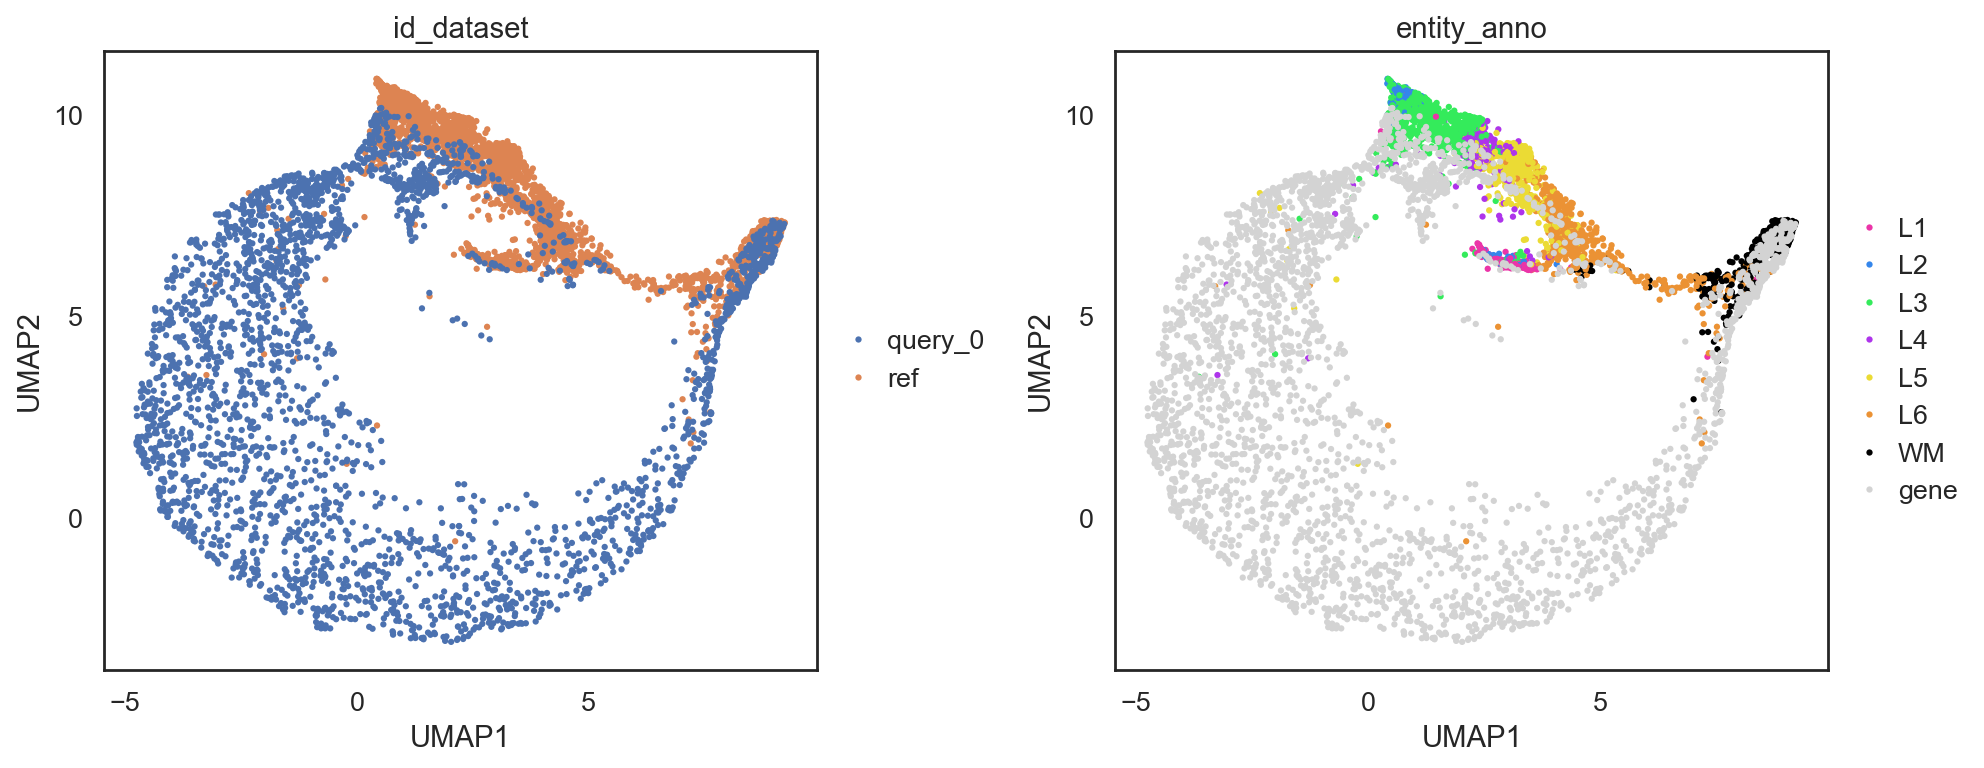

In [232]:
# obtain SIMBA embeddings of cells and variable genes
adata_all_var_genes = adata_all[list(adata_C.obs_names) + var_genes,].copy()
# visualize them using UMAP

si.pl.umap(adata_all_var_genes,color=['id_dataset','entity_anno'],
           dict_palette={'entity_anno': palette_entity_anno},
           drawing_order='original',
           fig_size=(6,5))
plt.show()